In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("..")  # if simulator.ipynb is in /notebooks/

from simulation.core import System
from simulation.controller import TrafficController
from simulation.data_logger import DataLogger
from simulation.core import Road, Obstacle
from simulation.spawners import timed_spawner, density_random_lane_spawner


In [6]:
def get_last_frame_average_velocity(df):
    if df.empty:
        print("No data logged.")
        return None
    last_time = df["time"].max()
    last_frame = df[df["time"] == last_time]
    return last_frame["velocity"].mean()

In [ ]:
dt = 0.1
sim_time = 500

num_cars = 500
starting_speed = 30

road_length = 200000
max_speed = 60

num_lanes = 5

def test_loop(n, should_print = False):

    dataframes = []

    for i in range(1, n):

        system = System(dt=dt, final_time=sim_time)

        start_pos = (0, 300)
        end_pos = (road_length, 300)
        road = Road(num_lanes, max_speed, start_pos, end_pos)

        system.add_road(road)
        logger = DataLogger(tag="basic_one_road_test")
        controller = TrafficController(system, logger=logger)

        controller.add_spawn_rule(density_random_lane_spawner(n, 0, num_cars, speed=starting_speed))

        for _ in range(int(sim_time / dt)):
            end = controller.control(dt, should_print=should_print)
            system.update(logger)

            if end:
                break

        df = logger.to_dataframe()
        dataframes.append(df)
        print("Logging to dataframe!")

    return dataframes


In [10]:
def compute_avg_velocity(df, N_total=None, plot=False):
    """
    Computes the average velocity over time from a dataframe and optionally plots the results.

    Parameters:
        df (pd.DataFrame): The dataframe containing 'time', 'velocity', and 'car_id' columns.
        N_total (int, optional): Total number of cars inserted. If None, skips padded average.
        plot (bool): If True, shows a plot of the average velocities.

    Returns:
        float: The total average velocity across the simulation.
    """

    grouped = df.groupby("time").agg(
        total_velocity=("velocity", "sum"),
        active_cars=("car_id", "nunique")
    )

    if N_total is not None:
        grouped["padded_avg_velocity"] = grouped["total_velocity"] / N_total

    grouped["real_avg_velocity"] = grouped["total_velocity"] / grouped["active_cars"]

    if plot:
        plt.figure(figsize=(10, 4))

        if N_total is not None:
            plt.plot(grouped.index, grouped["padded_avg_velocity"], label="Padded Avg Velocity", color='green', linewidth=2)

        plt.plot(grouped.index, grouped["real_avg_velocity"], label="Real Avg Velocity", color='red')
        plt.xlabel("Time (s)")
        plt.ylabel("Average Velocity (px/s)")
        plt.title("Average Velocity Over Time (Padded vs Real)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Return average over all time steps (real average)
    return grouped["real_avg_velocity"].mean()


The current time now is: 0.1
Inserting car with index:  1 at time: 0.1
Inserting car with index:  2 at time: 0.30000000000000004
Inserting car with index:  3 at time: 0.5
Inserting car with index:  4 at time: 0.7999999999999999
Inserting car with index:  5 at time: 0.9999999999999999
Inserting car with index:  6 at time: 1.3
Inserting car with index:  7 at time: 1.5000000000000002
Inserting car with index:  8 at time: 2.2000000000000006
Inserting car with index:  9 at time: 2.400000000000001
Inserting car with index:  10 at time: 2.600000000000001
Inserting car with index:  11 at time: 3.0000000000000013
Inserting car with index:  12 at time: 3.2000000000000015
Inserting car with index:  13 at time: 3.4000000000000017
Inserting car with index:  14 at time: 3.800000000000002
Inserting car with index:  15 at time: 4.100000000000001
Inserting car with index:  16 at time: 4.5
Inserting car with index:  17 at time: 4.899999999999999
Inserting car with index:  18 at time: 5.1999999999999975


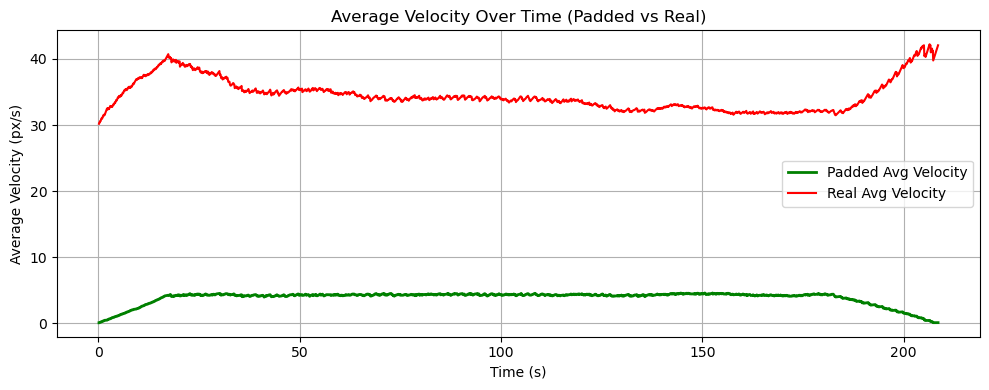

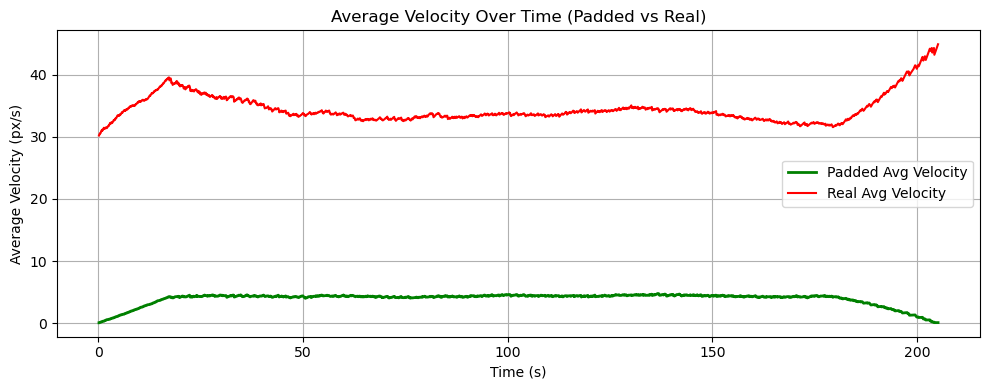

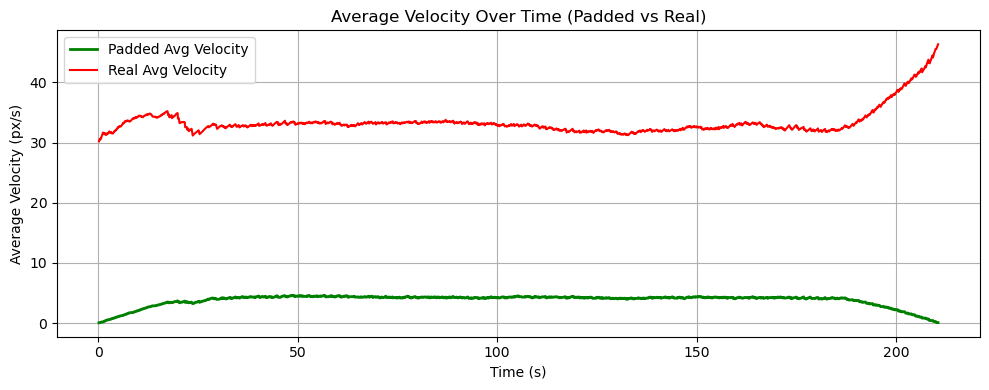

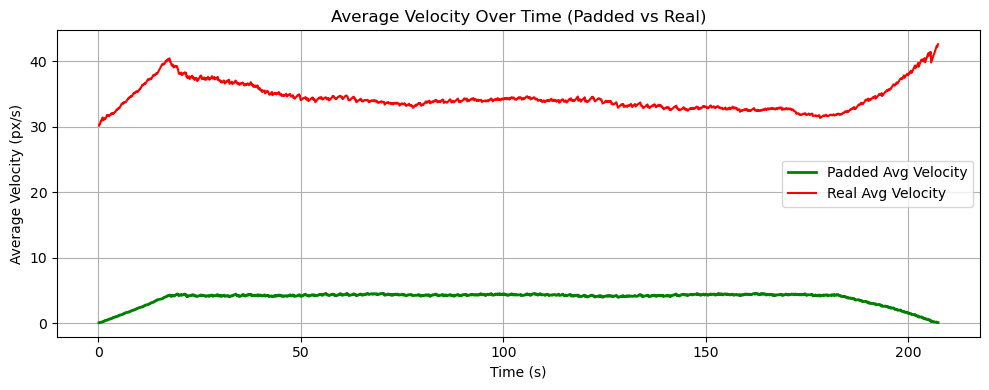

In [11]:
dataframes = test_loop(5)
for df in dataframes:
    compute_avg_velocity(df, N_total=500, plot = True)

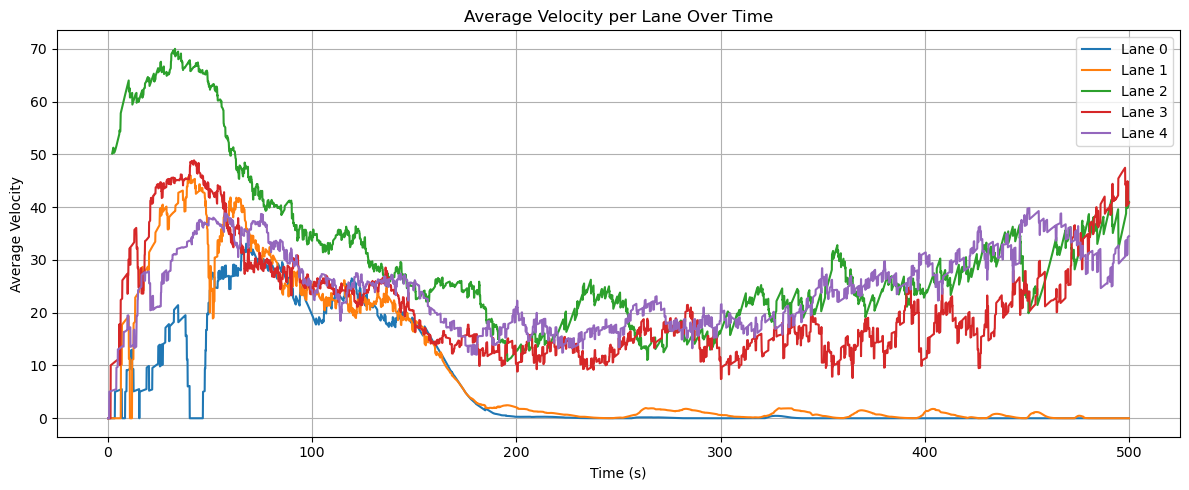

In [70]:
# Group by time and lane, then average velocity
avg_velocity_lane = df.groupby(["time", "lane_id"])["velocity"].mean().unstack()

# Plot each lane
plt.figure(figsize=(12, 5))
for lane in avg_velocity_lane.columns:
    plt.plot(avg_velocity_lane.index, avg_velocity_lane[lane], label=f"Lane {lane}")
plt.xlabel("Time (s)")
plt.ylabel("Average Velocity")
plt.title("Average Velocity per Lane Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


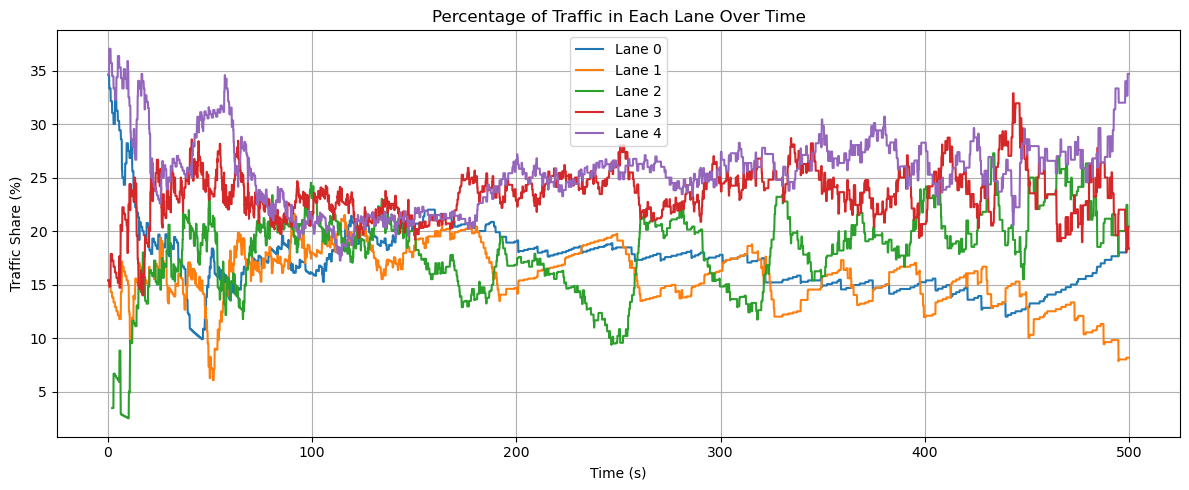

In [71]:
lane_counts = df.groupby(["time", "lane_id"])["car_id"].nunique().unstack()

# Convert to percentage of total cars at each time
lane_percentages = lane_counts.div(lane_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 5))
for lane in lane_percentages.columns:
    plt.plot(lane_percentages.index, lane_percentages[lane], label=f"Lane {lane}")

plt.xlabel("Time (s)")
plt.ylabel("Traffic Share (%)")
plt.title("Percentage of Traffic in Each Lane Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



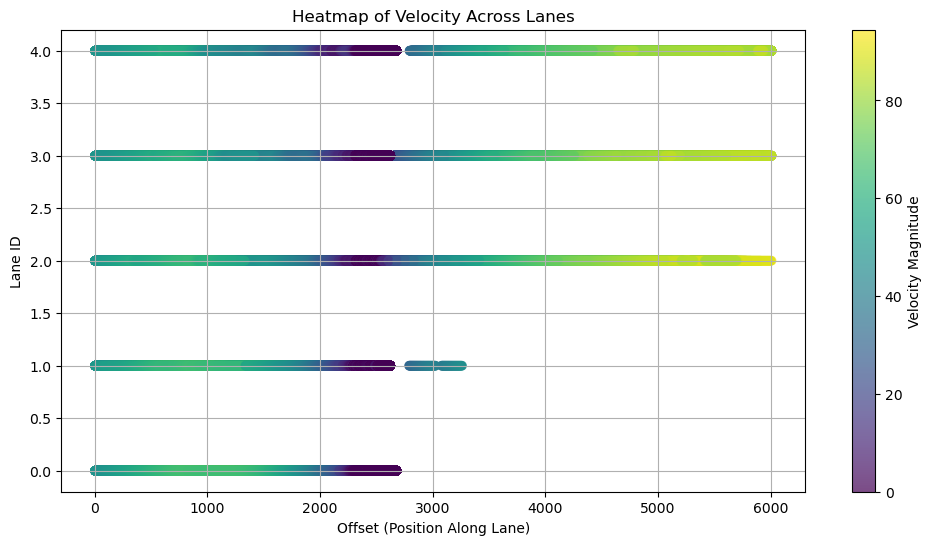

In [72]:
plt.figure(figsize=(12, 6))
sc = plt.scatter(df['offset'], df['lane_id'], c=df['velocity'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Velocity Magnitude')
plt.xlabel("Offset (Position Along Lane)")
plt.ylabel("Lane ID")
plt.title("Heatmap of Velocity Across Lanes")
plt.grid(True)
plt.show()

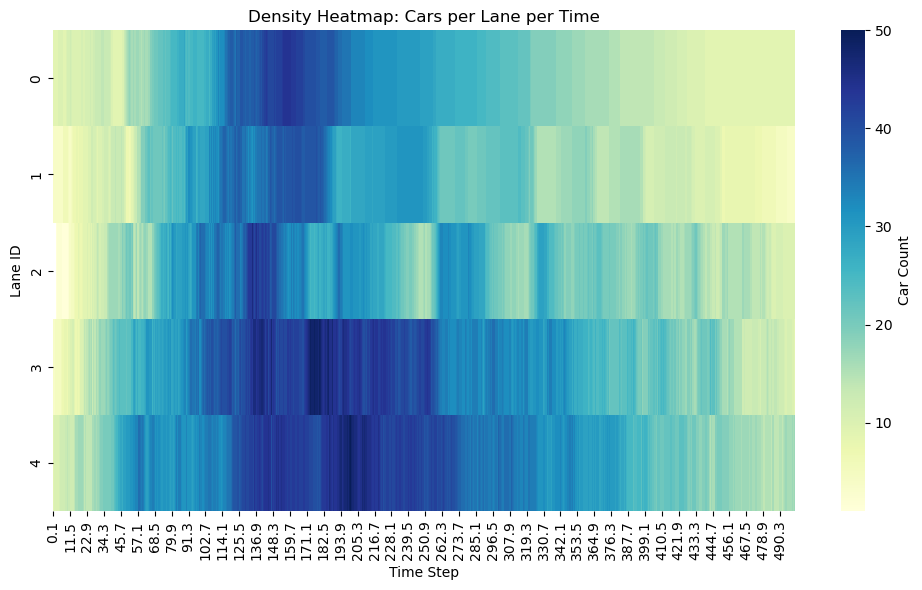

In [73]:
plt.figure(figsize=(10, 6))
sns.heatmap(lane_counts.T, cmap="YlGnBu", cbar_kws={"label": "Car Count"})
plt.title("Density Heatmap: Cars per Lane per Time")
plt.xlabel("Time Step")
plt.ylabel("Lane ID")
plt.tight_layout()
plt.show()
